## Importing Libraries

In [35]:
import pandas as pd
import numpy as np
import datetime as dt

In [ ]:
%pip install xlrd scipy matplotlib seaborn scikit-learn dmba

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Loading Dataset

In [37]:
import os

def get_dataset_file_path(file_name):
    # Get current working directory
    cwd = os.getcwd()

    # Construct relative path to the dataset
    relative_path = os.path.join(cwd, "..", "datasets", file_name)

    # Convert to absolute path
    absolute_path = os.path.abspath(relative_path)

    return absolute_path

# Example usage
file_name = "Book3.csv"
get_dataset_file_path(file_name)

'c:\\Users\\visha\\OneDrive\\Documents\\ML-Project\\Electricity_Load_n_Price_Forecasting\\datasets\\Book3.csv'

In [38]:
file_name = "Book3.csv"
file_path = get_dataset_file_path(file_name)
data = pd.read_csv(file_path)
display(data)

,Date,Hour,DryBulb,DewPnt,SYSLoad,NumDate
0,2004-01-01 00:00:00.0,1,37,25,12230,732000.0
1,2004-01-01 00:00:00.0,2,37,25,11534,732000.0
2,2004-01-01 00:00:00.0,3,39,24,11038,732000.0
3,2004-01-01 00:00:00.0,4,38,22,10777,732000.0
4,2004-01-01 00:00:00.0,5,37,20,10764,732000.0
...,...,...,...,...,...,...
52603,2009-12-31 00:00:00.0,20,28,25,17419,734000.0
52604,2009-12-31 00:00:00.0,21,27,25,16514,734000.0
52605,2009-12-31 00:00:00.0,22,27,25,15633,734000.0
52606,2009-12-31 00:00:00.0,23,27,24,14739,734000.0


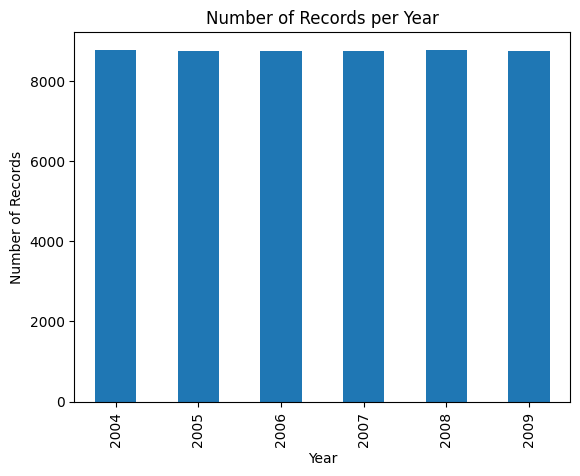

In [39]:
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

years_count = data['Date'].dt.year.value_counts().sort_index()
years_count.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.title('Number of Records per Year')
plt.show()


In [40]:
display(data.tail(1))

,Date,Hour,DryBulb,DewPnt,SYSLoad,NumDate
52607,2009-12-31,24,27,24,13953,734000.0


In [41]:
file_name = "Holidays.xls"
file_path = get_dataset_file_path(file_name)
hdata = pd.read_excel(file_path)
display(hdata.head())

,Date,Holiday
0,2004-01-01,New Year's Day
1,2004-01-19,Martin Luther King Day
2,2004-02-16,President's Day
3,2004-05-31,Memorial Day
4,2004-07-05,Independence Day


In [42]:
holidays=hdata.Date
holidays.head()

0   2004-01-01
1   2004-01-19
2   2004-02-16
3   2004-05-31
4   2004-07-05
Name: Date, dtype: datetime64[ns]

## Data Preprocessing

In [43]:
#Convert dates to datetime data type
data['Date']=pd.to_datetime(data['Date'])
data.dtypes

Date       datetime64[ns]
Hour                int64
DryBulb             int64
DewPnt              int64
SYSLoad             int64
NumDate           float64
dtype: object

In [44]:
#get the day of the week for each date in the data
dayofweek=data.Date.dt.weekday
dayofweek.head()

0    3
1    3
2    3
3    3
4    3
Name: Date, dtype: int32

In [45]:
isworkday = np.in1d(dayofweek,[0,1,2,3,4]) & ~np.in1d(data['Date'],holidays)
isworkday[22]

C:\Users\visha\AppData\Local\Temp\ipykernel_17224\1689000366.py:1: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  isworkday = np.in1d(dayofweek,[0,1,2,3,4]) & ~np.in1d(data['Date'],holidays)


np.False_

In [46]:
prevdaysamehour=np.hstack(((np.ones(24)*-1),(data['SYSLoad'][0:-24])))
prevdaysamehour[0]

np.float64(-1.0)

In [47]:
prevweeksamehour=np.hstack(((np.ones(168)*-1),(data['SYSLoad'][0:-168])))
prevweeksamehour.shape

(52608,)

In [48]:
import scipy
import scipy.signal
#By using the lfilter method get the previous 24 hour averrage temperature
prev24houravg = scipy.signal.lfilter(np.ones(24) / 24, 1, data['SYSLoad'])
prev24houravg.shape

(52608,)

In [49]:
#Put all the input data together into a single matrix
X = np.vstack((data['DryBulb'],data['DewPnt'],data['Hour'],dayofweek,isworkday,prevweeksamehour,prevdaysamehour,prev24houravg))
X.shape
display(pd.DataFrame(X.T).head(5))

,0,1,2,3,4,5,6,7
0,37.0,25.0,1.0,3.0,0.0,-1.0,-1.0,509.583333
1,37.0,25.0,2.0,3.0,0.0,-1.0,-1.0,990.166667
2,39.0,24.0,3.0,3.0,0.0,-1.0,-1.0,1450.083333
3,38.0,22.0,4.0,3.0,0.0,-1.0,-1.0,1899.125000
4,37.0,20.0,5.0,3.0,0.0,-1.0,-1.0,2347.625000


In [50]:
X=np.transpose(X)
X.shape

(52608, 8)

In [51]:
numcols=X.shape[1]

In [52]:
#Take out the first 168 indexes because they have null values
X=X[168:,:]
data=data[168:]
print(X.shape)
print(data.shape)

(52440, 8)
(52440, 6)


## Training and Testing Split

In [53]:
#Find the training index that will be used to split the data into train and test
trainInd = data.Date < dt.datetime(2008, 1, 1)
trainX = X[trainInd,:]
trainX.shape

(34896, 8)

In [54]:
#assign the training outputs
trainY=data.SYSLoad[trainInd]
trainY=trainY.to_numpy()
trainY = trainY.reshape((trainY.shape[0], 1))
trainY.shape

(34896, 1)

In [55]:
#split the range for the validation data
validX=X[34896:43680]
validX.shape
validX[-1]

array([ 8.0000000e+00, -5.0000000e+00,  2.4000000e+01,  2.0000000e+00,
        1.0000000e+00,  1.3253000e+04,  1.3827000e+04,  1.6115375e+04])

In [56]:
validY=data.SYSLoad[34896:43680]
validY=validY.to_numpy()
validY = validY.reshape((validY.shape[0], 1))
validY[-1]

array([15438])

In [57]:
testInd = data.Date>= dt.datetime(2009, 1, 1)
testX=X[testInd,:]
print(testX)

[[ 7.00000000e+00 -6.00000000e+00  1.00000000e+00 ...  1.21240000e+04
   1.28040000e+04  1.61936250e+04]
 [ 6.00000000e+00 -7.00000000e+00  2.00000000e+00 ...  1.13450000e+04
   1.21980000e+04  1.62724583e+04]
 [ 6.00000000e+00 -8.00000000e+00  3.00000000e+00 ...  1.08240000e+04
   1.19230000e+04  1.63455417e+04]
 ...
 [ 2.70000000e+01  2.50000000e+01  2.20000000e+01 ...  1.54490000e+04
   1.73440000e+04  1.58159167e+04]
 [ 2.70000000e+01  2.40000000e+01  2.30000000e+01 ...  1.47590000e+04
   1.59130000e+04  1.57670000e+04]
 [ 2.70000000e+01  2.40000000e+01  2.40000000e+01 ...  1.38030000e+04
   1.44660000e+04  1.57456250e+04]]


In [58]:
testY=data.SYSLoad[testInd]
testY=testY.to_numpy()
testY = testY.reshape((testY.shape[0], 1))

## Model Training

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from dmba import regressionSummary

# Train the Random Forest model
rf = RandomForestRegressor()
rf.fit(trainX, trainY.ravel())

# Predict and evaluate on the validation set
predY_rf = rf.predict(validX)
accuracy_rf = r2_score(validY, predY_rf)

# Metrics
print("Validation Set")
regressionSummary(validY, predY_rf)
print(f"Random Forest Validation R^2 Score: {accuracy_rf:.4f}")

Validation Set

Regression statistics

                      Mean Error (ME) : -34.7420
       Root Mean Squared Error (RMSE) : 402.3865
            Mean Absolute Error (MAE) : 284.4230
          Mean Percentage Error (MPE) : -0.2973
Mean Absolute Percentage Error (MAPE) : 1.8683
Random Forest Validation R^2 Score: 0.9799


## Model Evaluation

In [72]:
# Evaluation on the test set
print("Test Set")
predY_rf = rf.predict(testX)
regressionSummary(testY, predY_rf)
print(f"Random Forest Test R^2 Score: {r2_score(testY, predY_rf):.4f}")

Test Set

Regression statistics

                      Mean Error (ME) : -132.3665
       Root Mean Squared Error (RMSE) : 442.3063
            Mean Absolute Error (MAE) : 332.7567
          Mean Percentage Error (MPE) : -0.9754
Mean Absolute Percentage Error (MAPE) : 2.2883
Random Forest Test R^2 Score: 0.9749


## Actual vs Prediction Chart

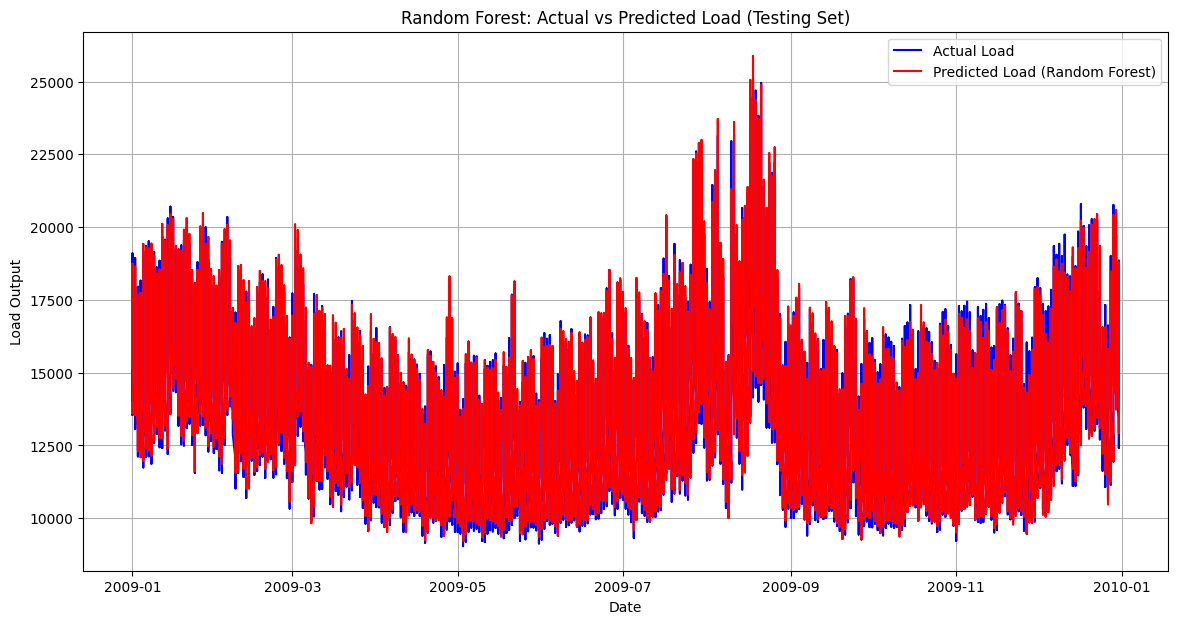

In [73]:
import matplotlib.pyplot as plt

# predictions on test set
predY_rf = rf.predict(testX)

# Extract dates for the validation set
validation_dates = data.Date[testInd]

# Plot actual vs predicted values for the test set using Random Forest predictions
plt.figure(figsize=(14, 7))
plt.plot(validation_dates, testY, label='Actual Load', color='blue')
plt.plot(validation_dates, predY_rf, label='Predicted Load (Random Forest)', color='red', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Load Output')
plt.title('Random Forest: Actual vs Predicted Load (Testing Set)')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# Storing Model inferences
import joblib
model_name = "random_forest_model.pkl"
model_file_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'inference', model_name))
joblib.dump(rf, model_file_path)
print(f"Model saved to {model_file_path}")

Model saved to c:\Users\visha\OneDrive\Documents\ML-Project\Electricity_Load_n_Price_Forecasting\inference\random_forest_model.pkl


In [79]:
# Storing compressed model
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from utils import save_compressed_model

# Compress and save the model
# utils/utils.py
filename = os.path.abspath(os.path.join(os.getcwd(), '..', 'inference', 'rfr.pkl'))
save_compressed_model(rf, filename=filename)

## Conclusion
1. Strong Pattern Recognition: The model effectively captures the overall load trends and seasonal patterns, showing high alignment between predicted and actual values.

2. Peak Load Challenges: Some deviations during peak periods suggest the model may underperform in extreme conditions, indicating room for improvement in handling volatility.

3. Reliable Forecasting Tool: The consistent tracking of fluctuations over time makes Random Forest a dependable choice for load forecasting in operational settings.

4. Robust Against Noise: Despite occasional mismatches, the ensemble nature of Random Forest helps smooth out irregularities, offering stable predictions across the dataset